In [76]:
import requests, json, re, time, random
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from itertools import combinations

def fetch_latest_listings():
    raw_url = "https://raw.githubusercontent.com/SimplifyJobs/New-Grad-Positions/dev/.github/scripts/listings.json"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(raw_url, headers=headers)
    response.raise_for_status()
    data = response.json()
    print(f"Retrieved {len(data)} listings from Simplify GitHub repo")
    return pd.DataFrame(data)

df = fetch_latest_listings()
df.head(3)

Retrieved 6697 listings from Simplify GitHub repo


,source,company_name,id,title,active,date_updated,date_posted,url,locations,company_url,is_visible,sponsorship,category,degrees
0,Simplify,Softheon,d07bb04b-8594-438b-96b7-62012419c15e,Software Engineer I - Membership,False,1744356258,1744356258,https://apply.workable.com/softheon/j/4AFE55D6...,"[Pittsburgh, PA]",https://simplify.jobs/c/Softheon,True,Other,NaN,NaN
1,Simplify,Esri,d6a226a8-f724-4077-b522-1d0088c5a431,Backend Java Engineer I - Data Pipelines,False,1744357547,1744357547,https://www.esri.com/careers/4700976007?gh_jid...,"[West Redlands, Redlands, CA]",https://simplify.jobs/c/Esri,True,Other,NaN,NaN
2,Simplify,Sony Interactive Entertainment,e50cce0a-7085-4a37-89dc-0ed7cfc54a68,Software Engineer I,False,1744381546,1744381546,https://job-boards.greenhouse.io/sonyinteracti...,"[San Diego, CA]",https://simplify.jobs/c/Sony-Interactive-Enter...,True,Other,NaN,NaN


In [78]:
simplify_df = (
    df[(df["is_visible"]) & (df["active"]) & (df["url"].notnull())]
    .copy()
)
simplify_df["locations"] = simplify_df["locations"].apply(
    lambda x: ", ".join(x) if isinstance(x, list) else str(x)
)
simplify_df = simplify_df[
    ["company_name", "title", "locations", "url"]
].rename(columns={"company_name": "Company", "title": "Role", "locations": "Location", "url": "URL"})

print(f"{len(simplify_df)} active postings")
simplify_df.sample(5)

2441 active postings


,Company,Role,Location,URL
4458,Artech Information System,Java Developer,"Reston, VA",https://jobs.smartrecruiters.com/ArtechInforma...
2134,LG Electronics,Development Engineer 1 - Contractor,"Troy, MI",https://job-boards.greenhouse.io/lgelectronics...
6009,Amazon,Agentic AI Teacher - Agi Ds,"Boston, MA, Bellevue, WA, United States",https://amazon.jobs/en/jobs/3132810/agentic-ai...
4966,ALTEN Technology,Data Collection Operator 1,SF,https://job-boards.greenhouse.io/altentechnolo...
3117,Truveta,Software Engineer - AI Platform,"Seattle, WA",https://job-boards.greenhouse.io/truveta/jobs/...


In [80]:
gh_df = simplify_df[
    simplify_df["URL"].str.contains("greenhouse", case=False, na=False)
].copy()

print(f"{len(gh_df)} Greenhouse postings")
gh_df.head()

302 Greenhouse postings


,Company,Role,Location,URL
70,Muon Space,Electrical Hardware Engineer – New Grad/Early ...,"Mountain View, CA",https://job-boards.greenhouse.io/muonspace/job...
76,Twitch,Software Engineer I,SF,https://job-boards.greenhouse.io/twitch/jobs/7...
329,mthree,Junior Software Engineer,"Salt Lake, UT, Houston, TX, Dalla, TX, New Yor...",https://job-boards.greenhouse.io/mthreerecruit...
461,Five Rings,Software Developer,"New York, NY",https://job-boards.greenhouse.io/fiveringsllc/...
511,TripAdvisor,Software Engineer I - Backend Focus - Viator,"London, UK, Oxford, UK",https://job-boards.greenhouse.io/tripadvisor/j...


In [82]:
def extract_greenhouse_requirements(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    
    try:
        html = requests.get(url, headers=headers, timeout=10)
        if html.status_code != 200:
            return None
        
        soup = BeautifulSoup(html.text, "html.parser")

        bullets = [li.get_text(" ", strip=True) for li in soup.find_all("li")]

        req_candidates = [
            b for b in bullets
            if any(keyword in b.lower() for keyword in ["experience", "degree", "python", "requirements"])
        ]

        if req_candidates:
            return " ".join(req_candidates)

        text = soup.get_text(" ", strip=True)
        match = re.search(r"(requirements|qualifications)(.*?)(preferred|about|salary|compensation|benefits)", 
                          text, flags=re.IGNORECASE | re.DOTALL)
        if match:
            return match.group(2).strip()

        return None
    except Exception as e:
        return None


gh_df["RawRequirements"] = gh_df["URL"].apply(extract_greenhouse_requirements)

print("Scraping complete")
gh_df.head()

Scraping complete


,Company,Role,Location,URL,RawRequirements
70,Muon Space,Electrical Hardware Engineer – New Grad/Early ...,"Mountain View, CA",https://job-boards.greenhouse.io/muonspace/job...,0-3 years of experience in hardware engineerin...
76,Twitch,Software Engineer I,SF,https://job-boards.greenhouse.io/twitch/jobs/7...,"Work with product managers, technical leads, a..."
329,mthree,Junior Software Engineer,"Salt Lake, UT, Houston, TX, Dalla, TX, New Yor...",https://job-boards.greenhouse.io/mthreerecruit...,Bachelor's degree in computer science or a rel...
461,Five Rings,Software Developer,"New York, NY",https://job-boards.greenhouse.io/fiveringsllc/...,None
511,TripAdvisor,Software Engineer I - Backend Focus - Viator,"London, UK, Oxford, UK",https://job-boards.greenhouse.io/tripadvisor/j...,None


In [84]:
def clean_text(text):
    if not isinstance(text, str):
        return None
    text = re.sub(r"\s+", " ", text)
    text = text.replace("\n", " ")
    text = re.sub(r"[^\x00-\x7F]+", "", text)
    return text.strip().lower()

gh_df["CleanRequirements"] = gh_df["RawRequirements"].apply(clean_text)

print("Cleaned requirements")
gh_df[["Company", "Role", "CleanRequirements"]].head()

Cleaned requirements


,Company,Role,CleanRequirements
70,Muon Space,Electrical Hardware Engineer – New Grad/Early ...,0-3 years of experience in hardware engineerin...
76,Twitch,Software Engineer I,"work with product managers, technical leads, a..."
329,mthree,Junior Software Engineer,bachelor's degree in computer science or a rel...
461,Five Rings,Software Developer,None
511,TripAdvisor,Software Engineer I - Backend Focus - Viator,None


In [86]:
LANGUAGE_PATTERNS = {
    "python": r"\bpython\b",
    "java": r"\bjava\b",
    "javascript": r"\bjavascript\b|\bjs\b",
    "typescript": r"\btypescript\b|\bts\b",
    "c": r"\bc(?!\+\+|#)\b",
    "c++": r"\bc\+\+\b",
    "c#": r"\bc#\b|\bcsharp\b",
    "go": r"\bgolang\b|\bgo\b",
    "rust": r"\brust\b",
    "sql": r"\bsql\b",
    "r": r"\br programming\b|\br language\b|\br\b",
    "scala": r"\bscala\b",
    "swift": r"\bswift\b",
    "kotlin": r"\bkotlin\b",
}

DEGREE_PATTERNS = {
    "bachelor": r"\bbachelor'?s\b|\bbs\b|\bb\.s\.?\b",
    "masters": r"\bmaster'?s\b|\bms\b|\bm\.s\.?\b",
    "phd": r"\bphd\b|\bph\.?d\.?\b|\bdoctorate\b",
}

EXPERIENCE_PATTERN = r"(\d+)\+?\s*(years|year|yrs|yr)(?:\s+(?:of\s+)?(experience|exp))?"

def extract_languages(text):
    if not isinstance(text, str):
        return []
    found = []
    for lang, pattern in LANGUAGE_PATTERNS.items():
        if re.search(pattern, text, flags=re.IGNORECASE):
            found.append(lang)
    return found


def extract_degrees(text):
    if not isinstance(text, str):
        return []
    found = []
    for deg, pattern in DEGREE_PATTERNS.items():
        if re.search(pattern, text, flags=re.IGNORECASE):
            found.append(deg)
    return found


def extract_experience(text):
    if not isinstance(text, str):
        return None
    matches = re.findall(EXPERIENCE_PATTERN, text, flags=re.IGNORECASE)
    if matches:
        years = [int(m[0]) for m in matches]
        return min(years)
    return None

gh_df["Languages"] = gh_df["CleanRequirements"].apply(extract_languages)
gh_df["Degrees"] = gh_df["CleanRequirements"].apply(extract_degrees)
gh_df["MinExperience"] = gh_df["CleanRequirements"].apply(extract_experience)

gh_df[["Company", "Role", "Languages", "Degrees", "MinExperience"]].head()

,Company,Role,Languages,Degrees,MinExperience
70,Muon Space,Electrical Hardware Engineer – New Grad/Early ...,[python],[],3.0
76,Twitch,Software Engineer I,"[typescript, go]",[bachelor],1.0
329,mthree,Junior Software Engineer,[],[bachelor],NaN
461,Five Rings,Software Developer,[],[],NaN
511,TripAdvisor,Software Engineer I - Backend Focus - Viator,[],[],NaN


In [88]:
from collections import Counter

lang_counts = Counter(lang for langs in gh_df["Languages"] for lang in langs)
pd.DataFrame(lang_counts.most_common(), columns=["Language","Count"])

,Language,Count
0,python,141
1,sql,41
2,java,34
3,c,31
4,r,26
5,javascript,24
6,go,18
7,typescript,14
8,scala,6
9,kotlin,3


In [90]:
deg_counts = Counter(deg for degs in gh_df["Degrees"] for deg in degs)
pd.DataFrame(deg_counts.most_common(), columns=["Degree","Count"])

,Degree,Count
0,bachelor,128
1,masters,36
2,phd,16


In [94]:
gh_df["MinExperience"].dropna().astype(int).value_counts().sort_index()

MinExperience
1     26
2     35
3      4
4      2
5      8
10     1
13     3
23     2
25     3
Name: count, dtype: int64

In [96]:
def tag_role(title: str):
    """Assign simple role tags based on keywords in the job title."""
    t = title.lower()
    tags = []

    if "data" in t:
        tags.append("ROLE_DATA")
    if "machine learning" in t or "ml " in t:
        tags.append("ROLE_ML")
    if "software engineer" in t or "swe" in t or "software developer" in t:
        tags.append("ROLE_SWE")
    if "backend" in t or "back-end" in t:
        tags.append("ROLE_BACKEND")
    if "frontend" in t or "front-end" in t or "full stack" in t:
        tags.append("ROLE_FRONTEND")

    if not tags:
        tags.append("ROLE_OTHER")
    return tags


def bucket_experience(years):
    """Convert numeric years of experience into coarse buckets."""
    if years is None or pd.isna(years):
        return None
    y = int(years)
    if y <= 1:
        return "EXP_0-1"
    elif y == 2:
        return "EXP_2"
    elif y == 3:
        return "EXP_3"
    elif 4 <= y <= 5:
        return "EXP_4-5"
    else:
        return "EXP_6+"

gh_df["RoleTags"] = gh_df["Role"].apply(tag_role)
gh_df["ExpBucket"] = gh_df["MinExperience"].apply(bucket_experience)

gh_df[["Company", "Role", "Languages", "Degrees", "MinExperience", "ExpBucket", "RoleTags"]].head()

,Company,Role,Languages,Degrees,MinExperience,ExpBucket,RoleTags
70,Muon Space,Electrical Hardware Engineer – New Grad/Early ...,[python],[],3.0,EXP_3,[ROLE_OTHER]
76,Twitch,Software Engineer I,"[typescript, go]",[bachelor],1.0,EXP_0-1,[ROLE_SWE]
329,mthree,Junior Software Engineer,[],[bachelor],NaN,None,[ROLE_SWE]
461,Five Rings,Software Developer,[],[],NaN,None,[ROLE_SWE]
511,TripAdvisor,Software Engineer I - Backend Focus - Viator,[],[],NaN,None,"[ROLE_SWE, ROLE_BACKEND]"


In [98]:
def build_transaction(row):
    items = []

    for lang in row["Languages"]:
        items.append(f"LANG_{lang}")

    for deg in row["Degrees"]:
        items.append(f"DEG_{deg}")

    if pd.notna(row["ExpBucket"]) and row["ExpBucket"] is not None:
        items.append(row["ExpBucket"])

    for tag in row["RoleTags"]:
        items.append(tag)

    return list(set(items))


transactions = gh_df.apply(build_transaction, axis=1)
transactions = [set(t) for t in transactions if t]

print(f"Built {len(transactions)} transactions for ARM.")
transactions[:3]

Built 302 transactions for ARM.


[{'EXP_3', 'LANG_python', 'ROLE_OTHER'},
 {'DEG_bachelor', 'EXP_0-1', 'LANG_go', 'LANG_typescript', 'ROLE_SWE'},
 {'DEG_bachelor', 'ROLE_SWE'}]

In [100]:
def apriori(transactions, min_support=0.05, max_len=3):
    """
    transactions: list of sets
    min_support: minimum fraction of transactions
    max_len: maximum size of itemsets to explore
    """
    n = len(transactions)
    
    item_counts = {}
    for t in transactions:
        for item in t:
            item_counts[item] = item_counts.get(item, 0) + 1

    freq_itemsets = {}
    Lk = {
        frozenset([item]): count / n
        for item, count in item_counts.items()
        if count / n >= min_support
    }
    freq_itemsets.update(Lk)

    k = 2
    while Lk and k <= max_len:
        candidates = set()
        items_list = list(Lk.keys())
        for i in range(len(items_list)):
            for j in range(i + 1, len(items_list)):
                union = items_list[i] | items_list[j]
                if len(union) == k:
                    candidates.add(union)

        ck_counts = {c: 0 for c in candidates}
        for t in transactions:
            for c in candidates:
                if c.issubset(t):
                    ck_counts[c] += 1

        Lk = {
            itemset: count / n
            for itemset, count in ck_counts.items()
            if count / n >= min_support
        }
        freq_itemsets.update(Lk)
        k += 1

    return freq_itemsets

freq_itemsets = apriori(transactions, min_support=0.05, max_len=3)
print(f"Found {len(freq_itemsets)} frequent itemsets.")
list(freq_itemsets.items())[:10]

Found 49 frequent itemsets.


[(frozenset({'LANG_python'}), 0.46688741721854304),
 (frozenset({'ROLE_OTHER'}), 0.4768211920529801),
 (frozenset({'DEG_bachelor'}), 0.423841059602649),
 (frozenset({'LANG_go'}), 0.059602649006622516),
 (frozenset({'EXP_0-1'}), 0.08609271523178808),
 (frozenset({'ROLE_SWE'}), 0.3708609271523179),
 (frozenset({'EXP_2'}), 0.11589403973509933),
 (frozenset({'DEG_phd'}), 0.052980132450331126),
 (frozenset({'DEG_masters'}), 0.11920529801324503),
 (frozenset({'LANG_c'}), 0.10264900662251655)]

In [102]:
def generate_rules(freq_itemsets, min_conf=0.6, min_lift=1.1):
    """
    freq_itemsets: dict {frozenset(items): support}
    Returns DataFrame of rules with support, confidence, lift.
    """
    support = freq_itemsets
    rules = []

    for itemset, supp in support.items():
        if len(itemset) < 2:
            continue
        items = list(itemset)
        for r in range(1, len(items)):
            for antecedent in combinations(items, r):
                antecedent = frozenset(antecedent)
                consequent = itemset - antecedent
                if not consequent:
                    continue

                supp_a = support.get(antecedent)
                supp_c = support.get(consequent)
                if not supp_a or not supp_c:
                    continue

                confidence = supp / supp_a
                lift = confidence / supp_c

                if confidence >= min_conf and lift >= min_lift:
                    rules.append(
                        {
                            "antecedent": ", ".join(sorted(antecedent)),
                            "consequent": ", ".join(sorted(consequent)),
                            "support": supp,
                            "confidence": confidence,
                            "lift": lift,
                        }
                    )

    rules_df = pd.DataFrame(rules)
    if not rules_df.empty:
        rules_df = rules_df.sort_values(["lift", "confidence"], ascending=False)
    return rules_df


rules_df = generate_rules(freq_itemsets, min_conf=0.6, min_lift=1.1)
print(f"Generated {len(rules_df)} association rules.")
rules_df.head(20)

Generated 28 association rules.


,antecedent,consequent,support,confidence,lift
24,LANG_r,"LANG_python, ROLE_OTHER",0.066225,0.769231,4.223776
16,LANG_java,"LANG_python, ROLE_SWE",0.086093,0.764706,3.724858
20,LANG_javascript,"LANG_python, ROLE_SWE",0.052980,0.666667,3.247312
1,LANG_go,ROLE_SWE,0.056291,0.944444,2.546627
17,"LANG_java, LANG_python",ROLE_SWE,0.086093,0.928571,2.503827
13,LANG_java,ROLE_SWE,0.096026,0.852941,2.299895
21,"LANG_javascript, LANG_python",ROLE_SWE,0.052980,0.842105,2.270677
0,LANG_javascript,ROLE_SWE,0.066225,0.833333,2.247024
3,DEG_masters,DEG_bachelor,0.109272,0.916667,2.162760
12,LANG_sql,LANG_python,0.132450,0.975610,2.089604


In [104]:
def filter_rules_by_consequent_prefix(rules, prefix):
    mask = rules["consequent"].str.contains(prefix)
    return rules[mask].head(20)

def filter_rules_by_antecedent_prefix(rules, prefix):
    mask = rules["antecedent"].str.contains(prefix)
    return rules[mask].head(20)

rules_lang = filter_rules_by_consequent_prefix(rules_df, "LANG_")
print("Rules predicting languages:")
rules_lang

Rules predicting languages:


,antecedent,consequent,support,confidence,lift
24,LANG_r,"LANG_python, ROLE_OTHER",0.066225,0.769231,4.223776
16,LANG_java,"LANG_python, ROLE_SWE",0.086093,0.764706,3.724858
20,LANG_javascript,"LANG_python, ROLE_SWE",0.052980,0.666667,3.247312
12,LANG_sql,LANG_python,0.132450,0.975610,2.089604
5,LANG_r,LANG_python,0.082781,0.961538,2.059465
26,"LANG_r, ROLE_OTHER",LANG_python,0.066225,0.952381,2.039851
27,"DEG_bachelor, LANG_sql",LANG_python,0.066225,0.952381,2.039851
18,"LANG_java, ROLE_SWE",LANG_python,0.086093,0.896552,1.920274
7,LANG_go,LANG_python,0.052980,0.888889,1.903861
23,"DEG_bachelor, LANG_java",LANG_python,0.052980,0.842105,1.803658


In [106]:
rules_deg = filter_rules_by_consequent_prefix(rules_df, "DEG_")
print("Rules predicting degrees:")
rules_deg

Rules predicting degrees:


,antecedent,consequent,support,confidence,lift
3,DEG_masters,DEG_bachelor,0.109272,0.916667,2.162760
19,"DEG_masters, LANG_python",DEG_bachelor,0.062914,0.863636,2.037642
10,EXP_0-1,DEG_bachelor,0.052980,0.615385,1.451923
14,LANG_c,DEG_bachelor,0.062914,0.612903,1.446069
11,EXP_2,DEG_bachelor,0.069536,0.600000,1.415625


In [108]:
rules_exp = filter_rules_by_consequent_prefix(rules_df, "EXP_")
print("Rules predicting experience:")
rules_exp

Rules predicting experience:


,antecedent,consequent,support,confidence,lift


In [110]:
rules_from_roles = filter_rules_by_antecedent_prefix(rules_df, "ROLE_")
print("Rules where role type implies skills/requirements:")
rules_from_roles

Rules where role type implies skills/requirements:


,antecedent,consequent,support,confidence,lift
26,"LANG_r, ROLE_OTHER",LANG_python,0.066225,0.952381,2.039851
18,"LANG_java, ROLE_SWE",LANG_python,0.086093,0.896552,1.920274
22,"LANG_javascript, ROLE_SWE",LANG_python,0.052980,0.800000,1.713475
15,"DEG_bachelor, ROLE_SWE",LANG_python,0.122517,0.637931,1.366349


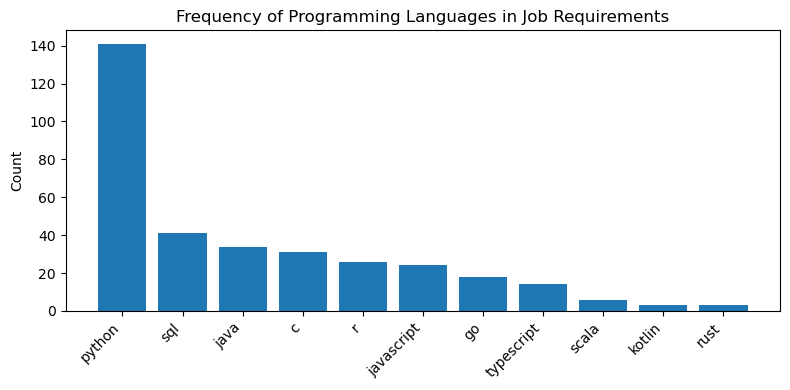

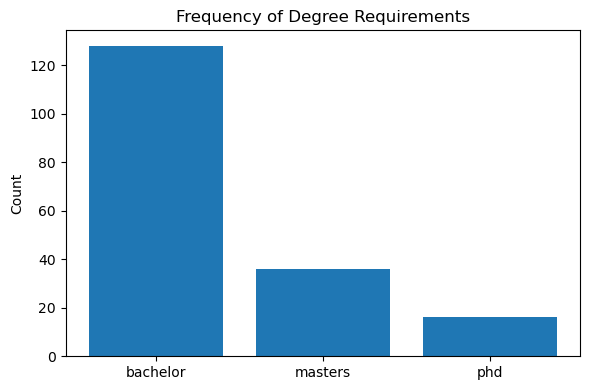

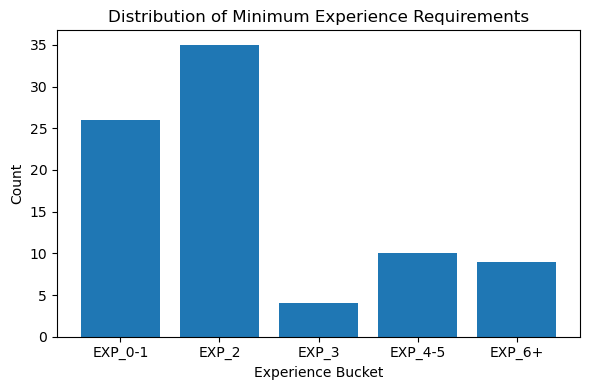

In [112]:
lang_counts = Counter(lang for langs in gh_df["Languages"] for lang in langs)
lang_df = pd.DataFrame(lang_counts.most_common(), columns=["Language", "Count"])

plt.figure(figsize=(8, 4))
plt.bar(lang_df["Language"], lang_df["Count"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.title("Frequency of Programming Languages in Job Requirements")
plt.tight_layout()
plt.show()

deg_counts = Counter(deg for degs in gh_df["Degrees"] for deg in degs)
deg_df = pd.DataFrame(deg_counts.most_common(), columns=["Degree", "Count"])

plt.figure(figsize=(6, 4))
plt.bar(deg_df["Degree"], deg_df["Count"])
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.title("Frequency of Degree Requirements")
plt.tight_layout()
plt.show()

exp_bucket_counts = gh_df["ExpBucket"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(exp_bucket_counts.index, exp_bucket_counts.values)
plt.ylabel("Count")
plt.xlabel("Experience Bucket")
plt.title("Distribution of Minimum Experience Requirements")
plt.tight_layout()
plt.show()

In [116]:
DATA_KEYWORDS = r"(data|machine learning|ml|analytics|ai)"
data_df = gh_df[gh_df["Role"].str.contains(DATA_KEYWORDS, case=False, regex=True)].copy()

print(f"Found {len(data_df)} data-related postings.")

data_df["HasMasters"] = data_df["Degrees"].apply(lambda d: "masters" in d)

masters_count = data_df["HasMasters"].sum()
total_data_roles = len(data_df)

print(f"Masters required/preferred in data roles: {masters_count}/{total_data_roles}")

masters_rate = masters_count / total_data_roles if total_data_roles > 0 else 0
print(f"Rate of master's requirement in data roles: {masters_rate:.2f}")

overall_masters_rate = gh_df["Degrees"].apply(lambda d: "masters" in d).mean()
print(f"Overall master's requirement rate: {overall_masters_rate:.2f}")

print("\nInterpretation:")
print(f"- Data roles require a master's degree {masters_rate/overall_masters_rate:.2f}x more often "
      f"than the average job posting (if >1).")

Found 68 data-related postings.
Masters required/preferred in data roles: 12/68
Rate of master's requirement in data roles: 0.18
Overall master's requirement rate: 0.12

Interpretation:
- Data roles require a master's degree 1.48x more often than the average job posting (if >1).


/var/folders/x4/d9l1qww13z53kp4k_fwt97080000gp/T/ipykernel_95058/3253528827.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_df = gh_df[gh_df["Role"].str.contains(DATA_KEYWORDS, case=False, regex=True)].copy()
